### Import library

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
class_names = ['land', 'water']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150,150)

### Load and preprocess the data

In [3]:
def load_data():
    
    datasets = ['train/', 'test/']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train/


100%|██████████| 1200/1200 [00:01<00:00, 722.58it/s]


Loading test/


100%|██████████| 300/300 [00:00<00:00, 834.02it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 3274
Number of testing examples: 818
Each image is of size: (150, 150)


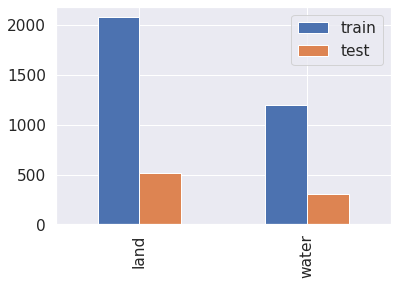

In [6]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names).plot.bar()
plt.show()

In [7]:
# Scale the images
train_images = train_images / 255.0 
test_images = test_images / 255.0

### Show image examples from the dataset

In [8]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] * 255).astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
    plt.show()

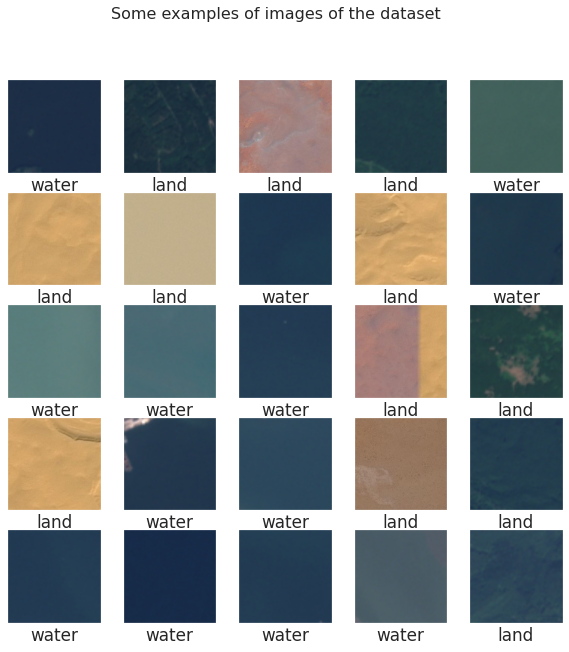

In [9]:
display_examples(class_names, train_images, train_labels)

### Build and train the model

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [11]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=270, validation_split = 0.2)

Epoch 1/270
21/21 [==============================] - 14s 651ms/step - loss: 0.6939 - accuracy: 0.6224 - val_loss: 0.5397 - val_accuracy: 0.5969
Epoch 2/270
21/21 [==============================] - 13s 640ms/step - loss: 0.5085 - accuracy: 0.6495 - val_loss: 0.4778 - val_accuracy: 0.7740
Epoch 3/270
21/21 [==============================] - 13s 641ms/step - loss: 0.4446 - accuracy: 0.7824 - val_loss: 0.3894 - val_accuracy: 0.8489
Epoch 4/270
21/21 [==============================] - 14s 644ms/step - loss: 0.4281 - accuracy: 0.7575 - val_loss: 0.3477 - val_accuracy: 0.8931
Epoch 5/270
21/21 [==============================] - 13s 642ms/step - loss: 0.3172 - accuracy: 0.8843 - val_loss: 0.3313 - val_accuracy: 0.8382
Epoch 6/270
21/21 [==============================] - 13s 634ms/step - loss: 0.2785 - accuracy: 0.8965 - val_loss: 0.3243 - val_accuracy: 0.8336
Epoch 7/270
21/21 [==============================] - 13s 625ms/step - loss: 0.3370 - accuracy: 0.8389 - val_loss: 0.3146 - val_accuracy:

### Evaluate the model

In [13]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(30,30))

    # Plot accuracy
    plt.subplot(211)
    plt.plot(history.history['accuracy'],'bo-', markersize = 3, label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro-',markersize = 3, label = "val_acc")
    plt.title("train_acc vs val_acc",fontsize=20)
    plt.ylabel("accuracy",fontsize=20)
    plt.xlabel("epochs")
    plt.legend(fontsize=20)

    # Plot loss function
    plt.subplot(212)
    plt.plot(history.history['loss'],'bo-', markersize = 3, label = "loss")
    plt.plot(history.history['val_loss'], 'ro-', markersize = 3, label = "val_loss")
    plt.title("train_loss vs val_loss",fontsize=20)
    plt.ylabel("loss",fontsize=20)
    plt.xlabel("epochs",fontsize=20)

    plt.legend(fontsize=20)
    plt.show()

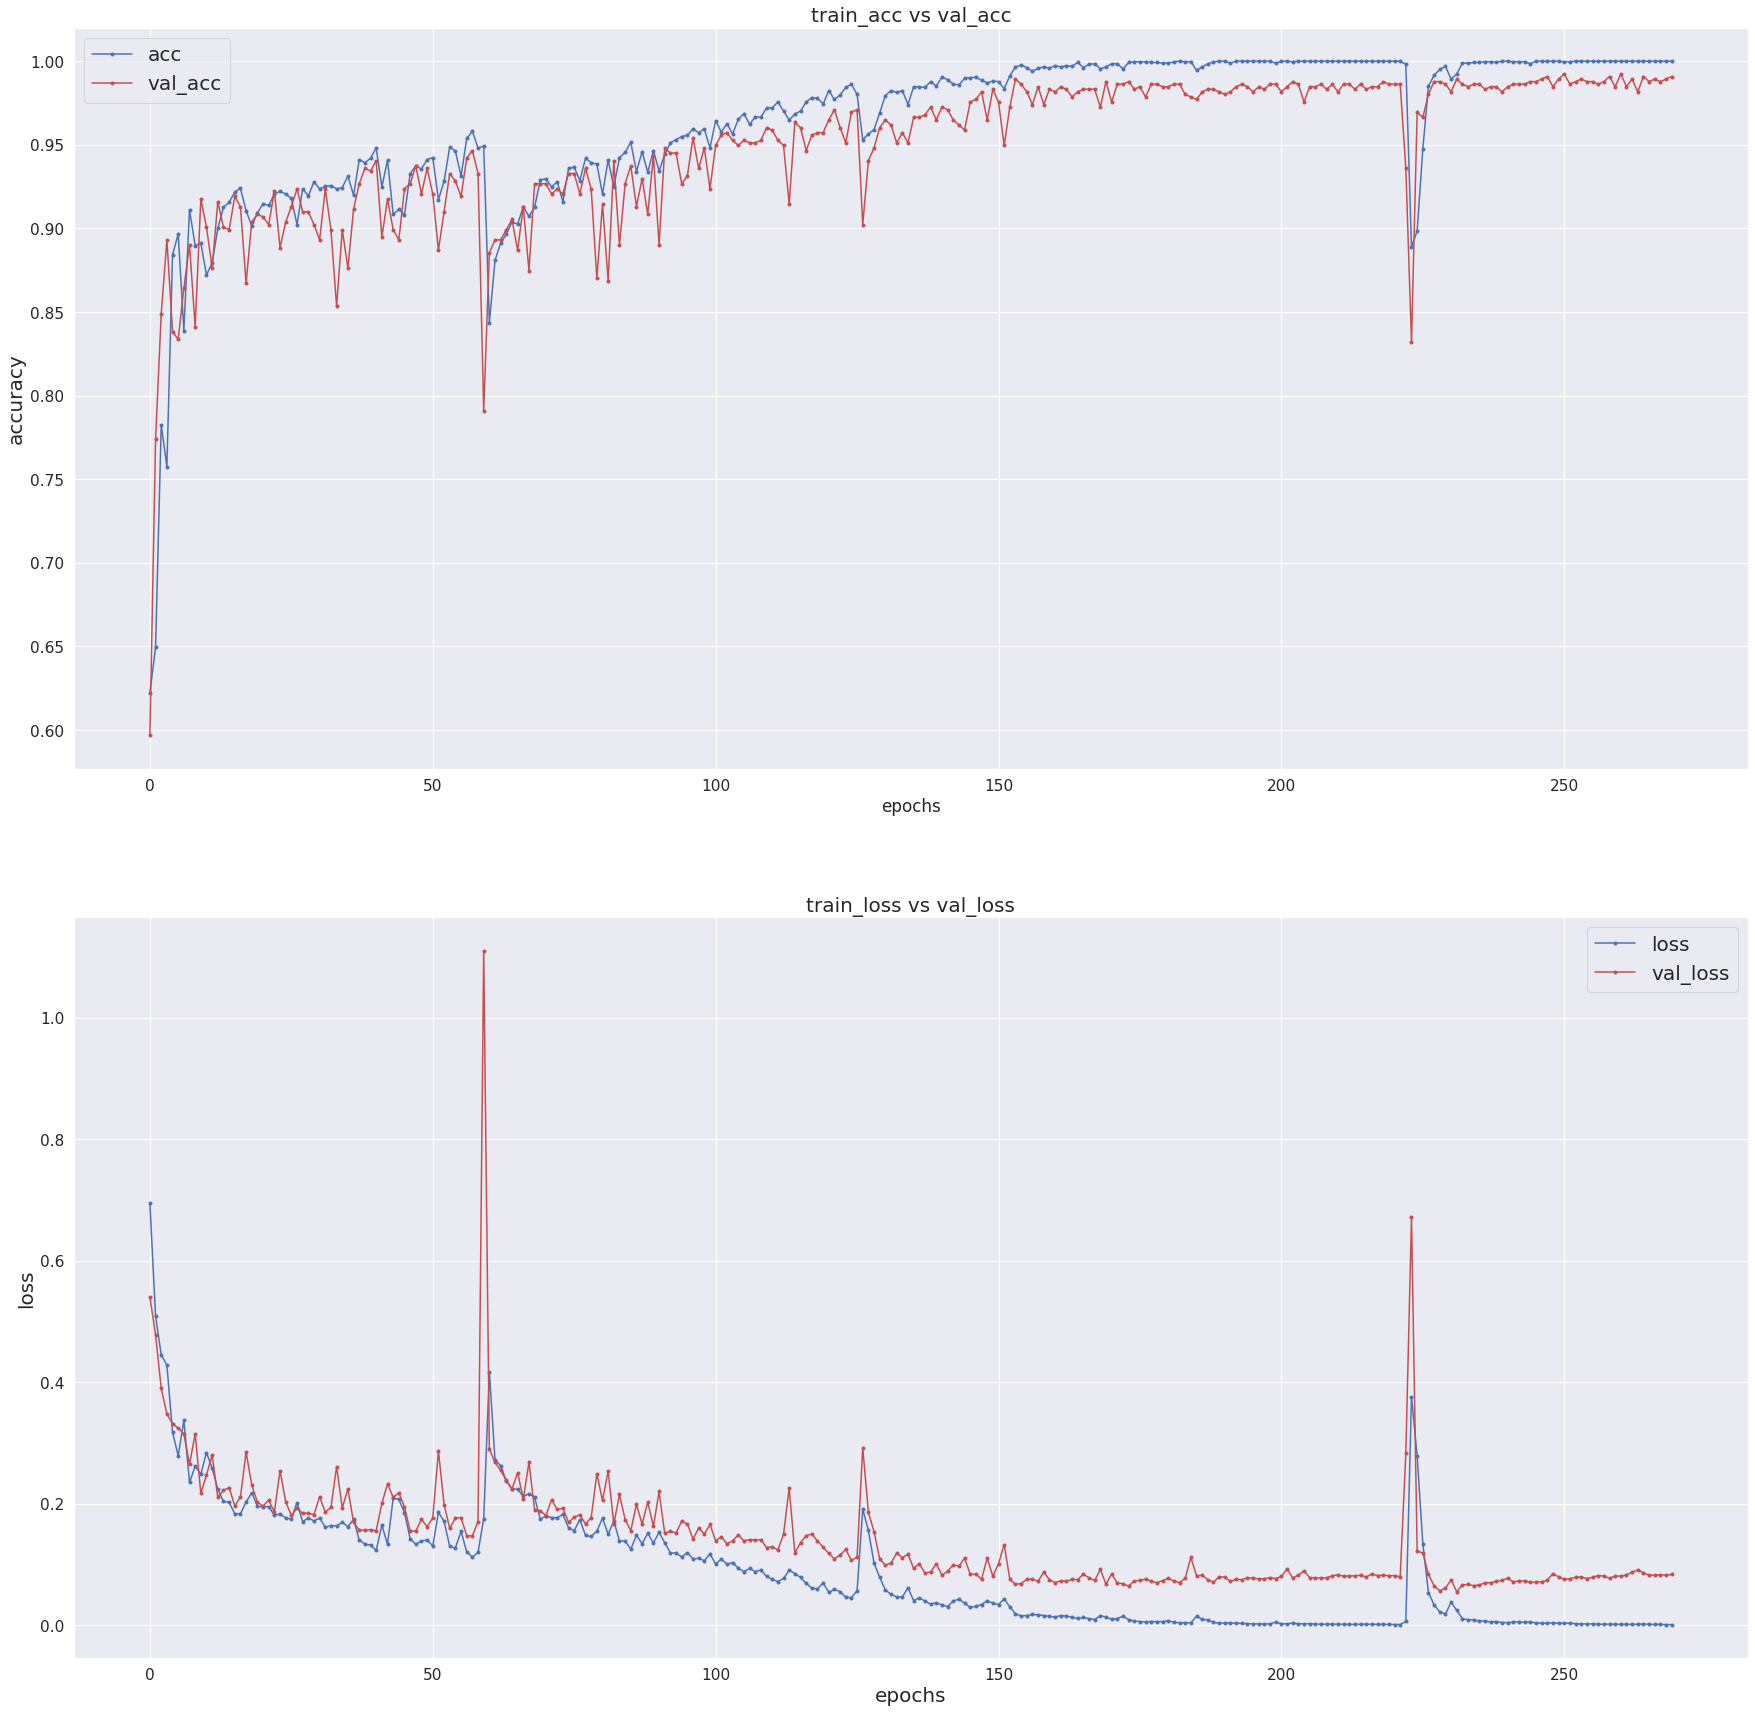

In [14]:
plot_accuracy_loss(history)

In [15]:
test_loss = model.evaluate(test_images, test_labels)

26/26 [==============================] - 1s 28ms/step - loss: 0.0488 - accuracy: 0.9829


#### The accuracy of the testing dataset is 98% !!!

In [16]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

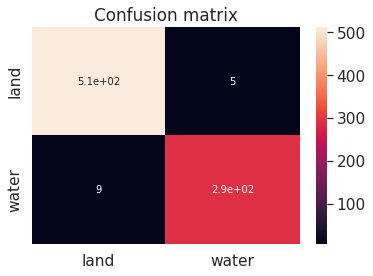

In [17]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [18]:
model.save('final_model.h5')